## Import Libraries



In [221]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.linalg import null_space
from google.colab import files
import time

## Define Transformation Matrices

In [222]:
def Rx(q):
    T = np.array([[1,         0,          0, 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, np.sin(q),  np.cos(q), 0],
                  [0,         0,          0, 1]], dtype=float)
    return T


def Ry(q):
    T = np.array([[ np.cos(q), 0, np.sin(q), 0],
                  [         0, 1,         0, 0],
                  [-np.sin(q), 0, np.cos(q), 0],
                  [         0, 0,         0, 1]], dtype=float)
    return T


def Rz(q):
    T = np.array([[np.cos(q), -np.sin(q), 0, 0],
                  [np.sin(q),  np.cos(q), 0, 0],
                  [        0,          0, 1, 0],
                  [        0,          0, 0, 1]], dtype=float)
    return T


def Tx(x):
    T = np.array([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def Ty(y):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def Tz(z):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]], dtype=float)
    return T

def skew(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """
    return np.array([[0, -vector[2], vector[1]], 
                     [vector[2], 0, -vector[0]], 
                     [-vector[1], vector[0], 0]])

## Forward Kinematics

In [223]:
def getLinkTransformations(T_base, q_active, q_passive, link):
  toLink1 = np.linalg.multi_dot([T_base, Tx(q_active[0]), Ry(q_passive[0]), Tx(link)])
  toLink2 = np.linalg.multi_dot([toLink1, Ry(q_passive[1]), Tx(link)])

  return toLink1, toLink2

## Inverse Kinematics

In [224]:
def ikPantograph(dz, link):
  # dz - vertical height of the robot
  # dx - horizontal distance from active joint
  dx = np.sqrt(link**2 - (dz**2)/4)
  q1 = np.arccos(dx/link)
  q3 = np.pi - q1
  q2 = q3 - q1
  return q1,q2,q3

## Define Local Stiffness Matrices K11, K12, K21, K22

In [225]:
def elementStiffness11(E, G, d, link):
    S = np.pi*(d**2)/4
    Iy = np.pi*(d**4)/64
    Iz = np.pi*(d**4)/64
    J = Iy + Iz
    
    K = np.array([[E*S/link,                 0,                 0,        0,                 0,                0],
                  [       0, 12*E*Iz/(link**3),                 0,        0,                 0, 6*E*Iz/(link**2)],
                  [       0,                 0, 12*E*Iy/(link**3),        0, -6*E*Iy/(link**2),                0],
                  [       0,                 0,                 0, G*J/link,                 0,                0],
                  [       0,                 0, -6*E*Iy/(link**2),        0,       4*E*Iy/link,                0],
                  [       0,  6*E*Iz/(link**2),                 0,        0,                 0,      4*E*Iz/link]], dtype=float)
    
    return K


def elementStiffness12(E, G, d, link):
    S = np.pi*(d**2)/4
    Iy = np.pi*(d**4)/64
    Iz = np.pi*(d**4)/64
    J = Iy + Iz
    
    K = np.array([[-E*S/link,                 0,                 0,        0,                 0,                0],
                  [        0,-12*E*Iz/(link**3),                 0,        0,                 0, 6*E*Iz/(link**2)],
                  [        0,                 0,-12*E*Iy/(link**3),        0, -6*E*Iy/(link**2),                0],
                  [        0,                 0,                 0,-G*J/link,                 0,                0],
                  [        0,                 0,  6*E*Iy/(link**2),        0,       2*E*Iy/link,                0],
                  [        0, -6*E*Iz/(link**2),                 0,        0,                 0,      2*E*Iz/link]], dtype=float)
    
    return K


def elementStiffness22(E, G, d, link):
    S = np.pi*(d**2)/4
    Iy = np.pi*(d**4)/64
    Iz = np.pi*(d**4)/64
    J = Iy + Iz
    
    K = np.array([[E*S/link,                 0,                 0,        0,                 0,                0],
                  [       0, 12*E*Iz/(link**3),                 0,        0,                 0,-6*E*Iz/(link**2)],
                  [       0,                 0, 12*E*Iy/(link**3),        0,  6*E*Iy/(link**2),                0],
                  [       0,                 0,                 0, G*J/link,                 0,                0],
                  [       0,                 0,  6*E*Iy/(link**2),        0,       4*E*Iy/link,                0],
                  [       0, -6*E*Iz/(link**2),                 0,        0,                 0,      4*E*Iz/link]], dtype=float)
    
    return K

## Define Matrix Q [Maps local stiffness matrix (k) to global stiffness matrix (K)]

In [226]:
def getMatrixQ(T_base, q_active, q_passive, link):
  Q = []
  for i in range(2):
      toLink1, toLink2 = getLinkTransformations(T_base, q_active[i], q_passive[i], link)

      rotationLink1 = toLink1[0:3, 0:3]
      rotationLink2 = toLink2[0:3, 0:3]

      zeros = np.zeros((3,3), dtype=float)

      Q1 = np.vstack([np.hstack([rotationLink1,         zeros]),
                      np.hstack([        zeros, rotationLink1])])

      Q2 = np.vstack([np.hstack([rotationLink2,         zeros]),
                      np.hstack([        zeros, rotationLink2])])

      Q.append([Q1, Q2])

  return Q[0], Q[1]

## Define Global Stiffness Matrix

In [227]:
def global_K(Q):
  K11 = np.linalg.multi_dot([Q, k11, np.transpose(Q)])
  K12 = np.linalg.multi_dot([Q, k12, np.transpose(Q)])
  K21 = np.linalg.multi_dot([Q, k21, np.transpose(Q)])
  K22 = np.linalg.multi_dot([Q, k22, np.transpose(Q)])
  
  return K11, K12, K21, K22

## Connection Types Functions

In [228]:
def rigid_support(node):
  m = np.zeros((6, 6*n*2))
  t = n + (node - start)
  m[0: 6, 6*t: 6*t+6] = np.eye(6)
  
  return m

In [229]:
def passive_support(node):
  m = np.zeros((6, 6*n*2))
  Wj = node - start
  
  tj = n + Wj
  m[0: 5, 6*tj: 6*tj+6] = lambda_r_y

  m[5, 6*Wj: 6*Wj+6] = lambda_p_y

  return m

In [230]:
def rigid_link(i,j):
  m = np.zeros((12, 6*n*2))
  Wi = i - start
  Wj = j - start
  m[0: 6, 6*Wi: 6*Wi+6] = np.eye(6)
  m[0: 6, 6*Wj: 6*Wj+6] = np.transpose(D)

  ti = n + Wi
  tj = n + Wj
  m[6: 12, 6*ti: 6*ti+6] = D
  m[6: 12, 6*tj: 6*tj+6] = -np.eye(6)

  return m

In [231]:
def flexible_link(i, j, Q):
  m = np.zeros((12, 6*n*2))
  Wi = i - start
  Wj = j - start
  m[0: 6, 6*Wi: 6*Wi+6] = -np.eye(6)
  m[6: 12, 6*Wj: 6*Wj+6] = -np.eye(6)
  
  K11, K12, K21, K22 = global_K(Q)
  
  ti = n + Wi
  tj = n + Wj
  m[0: 6, 6*ti: 6*ti+6] = K11
  m[0: 6, 6*tj: 6*tj+6] = K12
  m[6: 12, 6*ti: 6*ti+6] = K21
  m[6: 12, 6*tj: 6*tj+6] = K22

  return m 

In [232]:
def rigid_joint(i, j):
  m = np.zeros((12, 6*n*2))
  Wi = i - start
  Wj = j - start
  m[0: 6, 6*Wi: 6*Wi+6] = np.eye(6)
  m[0: 6, 6*Wj: 6*Wj+6] = np.eye(6)
  
  ti = n + Wi
  tj = n + Wj
  m[6: 12, 6*ti: 6*ti+6] = np.eye(6)
  m[6: 12, 6*tj: 6*tj+6] = -np.eye(6)

  return m

In [233]:
def passive_joint(i, j):
  m = np.zeros((12, 6*n*2))
  Wi = i - start
  Wj = j - start
  
  m[0: 5, 6*Wi: 6*Wi+6] = lambda_r_y
  m[0: 5, 6*Wj: 6*Wj+6] = lambda_r_y

  ti = n + Wi
  tj = n + Wj
  m[5: 10, 6*ti: 6*ti+6] = lambda_r_y
  m[5: 10, 6*tj: 6*tj+6] = -lambda_r_y

  m[10, 6*Wi: 6*Wi+6] = lambda_p_y
  m[11, 6*Wj: 6*Wj+6] = lambda_p_y

  return m

In [234]:
def elastic_joint(i, j):
  m = np.zeros((12, 6*n*2))
  Wi = i - start
  Wj = j - start

  m[0: 6, 6*Wi: 6*Wi+6] = np.eye(6)
  m[0: 6, 6*Wj: 6*Wj+6] = np.eye(6)

  ti = n + Wi
  tj = n + Wj
  m[6: 11, 6*ti: 6*ti+6] = lambda_r_x
  m[6: 11, 6*tj: 6*tj+6] = -lambda_r_x

  m[11, 6*Wi: 6*Wi+6] = lambda_e_x
  m[11, 6*ti: 6*ti+6] = K_active*lambda_e_x
  m[11, 6*tj: 6*tj+6] = -K_active*lambda_e_x

  return m

In [235]:
def external_load():
  m = np.zeros((6, 6*n*2))
  W = n - 1
  m[0: 6, 6*W: 6*W+6] = np.eye(6)

  return m

## Kc Calculation

In [236]:
def getKc(Q1, Q2):

  row1 = rigid_support(0) 

  row2 = flexible_link(3, 5, Q2[0])
  row3 = flexible_link(4, 6, Q1[0])
  row4 = flexible_link(7, 9, Q1[0])
  row5 = flexible_link(8, 10, Q2[0])
  row6 = flexible_link(11, 13, Q1[1])
  row7 = flexible_link(12, 14, Q2[1])
  row8 = flexible_link(15, 17, Q2[1])
  row9 = flexible_link(16, 18, Q1[1])

  row10 = passive_joint(0, 3)
  row11 = passive_joint(2, 4)
  row12 = passive_joint(5, 6)
  row13 = passive_joint(9, 11)
  row14 = passive_joint(10, 12)
  row15 = passive_joint(13, 14)
  row16 = passive_joint(17, 19)
  row17 = passive_joint(18, 20)
  row18 = passive_joint(19, 20)

  row19 = elastic_joint(1, 2)

  row20 = rigid_joint(0, 1)
  row21 = rigid_joint(5, 8)
  row22 = rigid_joint(6, 7)
  row23 = rigid_joint(13, 16)
  row24 = rigid_joint(14, 15)

  row25 = external_load()
  
  M = np.concatenate((row1, row2, row3, row4, row5, row6, row7, row8, row9,
                      row10, row11, row12, row13, row14, row15, row16, row17, row18,
                      row19, row20, row21, row22, row23, row24, row25), axis = 0)

  A = M[0:282, 0:246]
  B = M[0:282, 246:252]
  C = M[282:288, 0:246]
  D = M[282:288, 246:252]


  A_pinv = np.linalg.pinv(A)
  New = np.linalg.multi_dot([C, A_pinv])
  Kc = D - np.linalg.multi_dot([New, B])

  AB = np.concatenate((A,B), axis = 1)

  return Kc, M, AB

## Main Deflection Calculations

In [237]:
def CalculateDeflections(T_base, externalForce, link):

  zlinSpace = np.linspace(0.1, dz_limit, 30)    

  zData = np.array([])
  dData = np.array([])
  
  with open('MSA_deflection.txt', 'a') as f:
    for dz in zlinSpace:
      q1,q2,q3 = ikPantograph(dz, link)
      q_passive = [np.array([-q1, -q2, q3]), np.array([-q3, q2, q1])]
      dx = np.cos(q1)*link/2
      q_active = [np.array([-dx, dx]), np.array([dx, -dx])]
      Q1, Q2 = getMatrixQ(T_base, q_active, q_passive, link)
      
      Kc, M, AB = getKc(Q1,Q2)
      dt1 = np.linalg.pinv(Kc).dot(externalForce)
      #######################################################################

      pinv_M = np.linalg.pinv(M)
      pinv_Kc = pinv_M[282:288, 246:252]
      zeros = np.zeros((282,1))
      v = np.concatenate((zeros, externalForce), axis = 0)
      X = pinv_M.dot(v) # null_space(M).dot(np.array([[1],[1]]))
      dt2 = X[246:252]

      #######################################################################
      
      M_ = np.concatenate((AB[:,0:20*6], AB[:,21*6:]), axis = 1)
      pinv_M_ = np.linalg.pinv(M_)
      v_ = -AB[:,20*6:21*6].dot(externalForce)
      X_ = pinv_M_.dot(v_) 
      dt3 = X_[240:246]
      
      #######################################################################

      deflection = np.sqrt(dt2[0] ** 2 + dt2[1] ** 2 + dt2[2] ** 2)
      f.write(str(deflection[0]))
      f.write("\n")

      zData = np.append(zData, dz)
      dData = np.append(dData, deflection)
    

  return zData, dData 

## Plot Pantograph

In [238]:
def plotPantograph(dz, link):
  q1,q2,q3 = ikPantograph(dz, link)
  q_passive = [np.array([-q1, -q2, q3]), np.array([-q3, q2, q1])]
  dx = np.cos(q1)*link/2
  q_active = [np.array([-dx, dx]), np.array([dx, -dx])]

  for i in range(2):
    x = []
    z = []
    toLink1, toLink2 = getLinkTransformations(T_base, q_active[i], q_passive[i], link)
    link_1 = toLink1[0:3, 3]
    link_2 = toLink2[0:3, 3]
  
    x.extend([q_active[i][0], link_1[0], link_2[0]])
    z.extend([0, link_1[2], link_2[2]])
    plt.plot(x, z, color='dimgrey', linewidth=5)
    plt.scatter(x,z, s=100, marker='o', color='purple')
  
  plt.plot([-dx, dx],[0, 0], color='violet', linewidth=3)
  plt.plot([-dx, dx],[dz, dz], color='green', linewidth=3)
  plt.scatter([0, 0],[dz/4, 3*dz/4], s=150, marker='o', color='purple')
  plt.title('Pantograph Model')
  plt.xlabel('x-axis', fontsize=20)
  plt.ylabel('z-axis', fontsize=20)
  plt.xlim([-0.25, 0.25])
  plt.ylim([-0.1, 1])
  plt.grid()
  plt.savefig("Pantograph Model.png")
  plt.show()

## Plot Deflection Map

In [239]:
def plotDeflectionMap(z_pos, deflection, figureName):
  plt.scatter(z_pos, deflection)
  plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
  plt.ylabel('Deflection \u0394t (m)', fontsize=20)
  plt.xlabel('z', fontsize=20)
  plt.savefig(figureName)
  plt.show()

## Initialize Constant Values

In [240]:
n = 21 # total number of nodes
start = 0 # first node is 0

T_base = np.eye(4, dtype=float)
T_tool = Ty(0)

link = 0.5 # links length
d = 0.03 # links diameter
dz_limit = 0.9 # Maximum height is 1 m 
K_active = 1000000 # actuator stiffness
E = 7.0000e+10 # Young's modulus
G = 2.5500e+10 # shear modulus

platform_as_rigid_link = np.array([0.25, 0.25, 0]) # translation from 20 to e
d_skew = skew(platform_as_rigid_link)
D = np.zeros((6,6))
# D[0:3, 0:3] = D[3:6, 3:6] = np.eye(3)
D[0:3, 3:6] = np.transpose(d_skew)

k11 = elementStiffness11(E, G, d, link)
k12 = elementStiffness12(E, G, d, link)
k21 = np.transpose(k12)
k22 = elementStiffness22(E, G, d, link)

# Define Lambdas
lambda_r_y = np.array([[1, 0, 0, 0, 0, 0],
                       [0, 1, 0, 0, 0, 0],
                       [0, 0, 1, 0, 0, 0],
                       [0, 0, 0, 1, 0, 0],
                       [0, 0, 0, 0, 0, 1]])

lambda_p_y = np.array([0, 0, 0, 0, 1, 0])

lambda_e_x = np.array([1, 0, 0, 0, 0, 0])

lambda_r_x = np.array([[0, 1, 0, 0, 0, 0],
                       [0, 0, 1, 0, 0, 0],
                       [0, 0, 0, 1, 0, 0],
                       [0, 0, 0, 0, 1, 0],
                       [0, 0, 0, 0, 0, 1]])

## Final Output

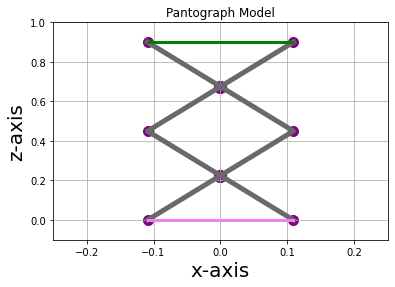

In [241]:
plotPantograph(dz_limit, link)
# files.download("Pantograph Model.png")

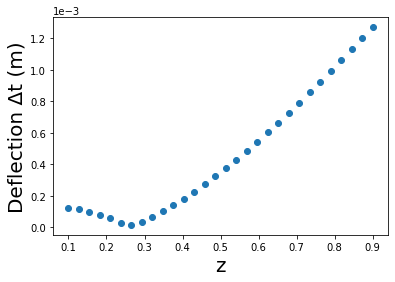

2.9603278636932373


In [242]:
externalForce = np.array([[0], [100], [0], [0], [0], [0]])
t = time.time()
z_pos, deflection = CalculateDeflections(T_base, externalForce, link)
figureName = "MSA_DeflectionMap_y.png"
plotDeflectionMap(z_pos, deflection, figureName)
elapsed = time.time() - t
print(elapsed)
# files.download(figureName)